In [109]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from utils_cosm import MHI_Modi2019, MHI_Padmanabhan2017
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## INITIAL ANALYSIS WORKING ON A SINGLE FILE INSIDE FOLDER LH{i_run}

#### Importing data and visualizing distributions

In [23]:
# Since we are working on a restriced version of the dataset, we should ensure that i_run belongs to [0,9]
# i_z belongs to [0,15]
# i_run refers to the choice of the parameters.Then, for each choice, we have 16 subfiles corresponding to different zs

i_run, i_z = 0, 0 # This means we work using LH_0 and z = 2.63

path_in = './outputs_test/LH_%d/' %(i_run)
path_out = path_in

redshift = np.loadtxt('./outputs_test/redshifts.txt', usecols=(1))
params = np.loadtxt('./outputs_test/params_IllustrisTNG.txt')

z = redshift[i_z]
#t_back = cosmo.lookback_time(z).to(u.Myr)
print('z=%.3f' %(z))

print('Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2')
print(params[i_run])

z=2.630
Om0	sigma8	Asn1	Aagn1	Asn2	Aagn2
[0.309   0.979   3.11234 1.12194 0.6685  0.53182]


In [51]:
# Importing data
f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))
mHalo = f['MassHalo'][:]
mHI = f['M_HI'][:]
print(mHalo.size)
f.close()

24838


In [27]:
# Generating the simulated data
mass = np.logspace(8, 14, 1000)
mHI_modelA = MHI_Modi2019(Mh=mass, z=z, model='A')
mHI_modelC = MHI_Modi2019(Mh=mass, z=z, model='C')

mHI_Pad = MHI_Padmanabhan2017(Mh=mass, z=z, Om0=params[i_run, 0], delta_c=200.)

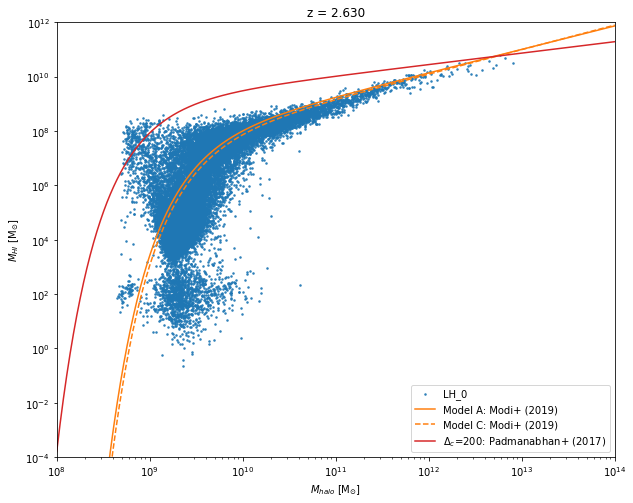

(None, None)

<Figure size 432x288 with 0 Axes>

In [29]:
plt.figure(figsize = (10,8))
plt.title('z = %.3f' %z)

plt.scatter(x=mHalo, y=mHI, s=10, color='tab:blue', label=r'LH_%d' %i_run, marker='.', alpha=0.8)
plt.plot(mass, mHI_modelA, label='Model A: Modi+ (2019)', color='tab:orange', ls='-')
plt.plot(mass, mHI_modelC, label='Model C: Modi+ (2019)', color='tab:orange', ls='--')
plt.plot(mass, mHI_Pad, label=r'$\Delta_c$=200: Padmanabhan+ (2017)', color='tab:red', ls='-')

plt.xscale('log'), plt.yscale('log')
plt.xlim(1e8, 1e14), plt.ylim(1e-4, 1e12)
plt.xlabel(r'$M_{halo}$ $\rm{[M_{\odot}]}$')
plt.ylabel(r'$M_{HI}$ $\rm{[M_{\odot}]}$')
plt.legend(loc=4)

plt.savefig('%scompare_MHI_LH%d_z%.3f.png' %(path_out, i_run, z), bbox_inches='tight', facecolor='white')
plt.show(), plt.clf()

In this first analysis we consder M_HI as a known feature. In order to reply the pipeline described in the tutorial, we first need to discretize the continuos feature. It seems reasonable, considering the scatter plot above, to categorize the variable defining bins using quantiles. To this extent, we use pd.qcut.

We first need to impor the data. To better handle them, we decide to create a dataframe starting from the data in the analysed file.

In [67]:
# Defining feature names

new_features = ['MassHalo','VelHalo','Nsubs','MassBH','dotMassBH','PosHalo',
                'MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0',
                'MetalsStar_1','MetalsStar_2','SFR','M_HI']

# Defining a new dataset

f = h5py.File('%sMHI_LH%d_z=%.3f.hdf5' %(path_in, i_run, z))

MHalo = f['MassHalo']
VelHalo = f['VelHalo']
Nsubs = f['Nsubs']
MassBH = f['MassBH']
dotMassBH = f['dotMassBH']
posHalo = f['PosHalo']
MetalsGas = f['MetalsGas']
MetalsStar = f['MetalsStar']
SFR = f['SFR']
M_HI = f['M_HI']

data = np.empty((MHalo.size,len(new_features)))

data[:,0] = MHalo

# Instead of saving the velocity of the Halo among each canonical direction, we decide to summarize them by compute 
# the norm of the valocity. By doing so, we not only reduce the dimension of our data (extremely useful to avoid the 
# curse of dimensionality), but we ensure to reduce the computation without losing useful information.

data[:,1] = np.linalg.norm(VelHalo, axis = 1)
data[:,2] = Nsubs
data[:,3] = MassBH
data[:,4] = dotMassBH

# Since the model does not take into account the interaction among different Halos, there is no need to save the coordinates
# along different dimension but it is enough to save the norm of the vector indicating the distance of the Halo from the
# centre of the simulation

data[:,5] = np.linalg.norm(posHalo, axis = 1)

data[:,6] = MetalsGas[:,0]
data[:,7] = MetalsGas[:,1]
data[:,8] = MetalsGas[:,2]
data[:,9] = MetalsStar[:,0]
data[:,10] = MetalsStar[:,1]
data[:,11] = MetalsStar[:,2]
data[:,12] = SFR
data[:,13] = M_HI

df = pd.DataFrame(data, columns = new_features)
print(df.shape)
df.sample(5)
    

(24838, 14)


,MassHalo,VelHalo,Nsubs,MassBH,dotMassBH,PosHalo,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2,SFR,M_HI
15366,2.908094e+09,228.026535,1.0,0.0,0.0,17.015482,0.760000,0.240000,8.000000e-10,0.0,0.0,0.0,0.0,5658.858807
19915,1.816946e+09,372.581543,0.0,0.0,0.0,24.427105,0.759960,0.240021,1.903324e-05,0.0,0.0,0.0,0.0,5352.681529
11618,4.236709e+09,161.048660,0.0,0.0,0.0,28.807030,0.759706,0.240128,1.661898e-04,0.0,0.0,0.0,0.0,135.380647
15181,2.415809e+09,278.402588,1.0,0.0,0.0,18.585157,0.760000,0.240000,8.000000e-10,0.0,0.0,0.0,0.0,120083.991501
15692,2.506133e+09,190.779816,1.0,0.0,0.0,29.626143,0.760000,0.240000,7.998188e-10,0.0,0.0,0.0,0.0,17363.750772


We discretize the variable 'M_HI'. By doing so, we know that each bin contains the same amount of data points.

In [68]:
df['M_HI'] = pd.qcut(df.M_HI,[0,.25,.5,.75,1], labels = ['very_low_HI','low_HI','high_HI','very_high_HI'])
df.sample(5)

,MassHalo,VelHalo,Nsubs,MassBH,dotMassBH,PosHalo,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2,SFR,M_HI
8300,3.593177e+09,222.306946,1.0,0.0,0.0,22.531027,0.760000,0.24000,7.985889e-10,0.0,0.0,0.0,0.0,very_high_HI
7246,3.787850e+09,143.924164,1.0,0.0,0.0,8.041359,0.760000,0.24000,1.001253e-09,0.0,0.0,0.0,0.0,very_high_HI
18067,1.678996e+09,154.064499,0.0,0.0,0.0,22.777231,0.759914,0.24004,4.644700e-05,0.0,0.0,0.0,0.0,low_HI
9553,4.139163e+09,196.301804,1.0,0.0,0.0,18.039106,0.760000,0.24000,7.999997e-10,0.0,0.0,0.0,0.0,low_HI
23155,1.655391e+09,277.582214,1.0,0.0,0.0,31.216776,0.760000,0.24000,7.965679e-10,0.0,0.0,0.0,0.0,very_low_HI


'MetalsGas' and 'MetalsStar' seem to be very concentrated unless for very few observations. We decide to visualize the distributions of these features to better understand how to handle them.

In [108]:
df[['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']].describe()

,MetalsGas_0,MetalsGas_1,MetalsGas_2,MetalsStar_0,MetalsStar_1,MetalsStar_2
count,24838.000000,24838.000000,2.483800e+04,24838.000000,24838.000000,24838.000000
mean,0.759575,0.240014,8.864283e-05,0.062024,0.019621,0.000045
std,0.013673,0.004344,4.858848e-04,0.207960,0.065787,0.000522
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.759998,0.240000,8.000000e-10,0.000000,0.000000,0.000000
50%,0.760000,0.240000,8.340466e-10,0.000000,0.000000,0.000000
75%,0.760000,0.240001,1.091075e-06,0.000000,0.000000,0.000000
max,0.760000,0.251941,1.432272e-02,0.760000,0.249917,0.021299


array([[<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>],
       [<AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>,
        <AxesSubplot:ylabel='Frequency'>]], dtype=object)

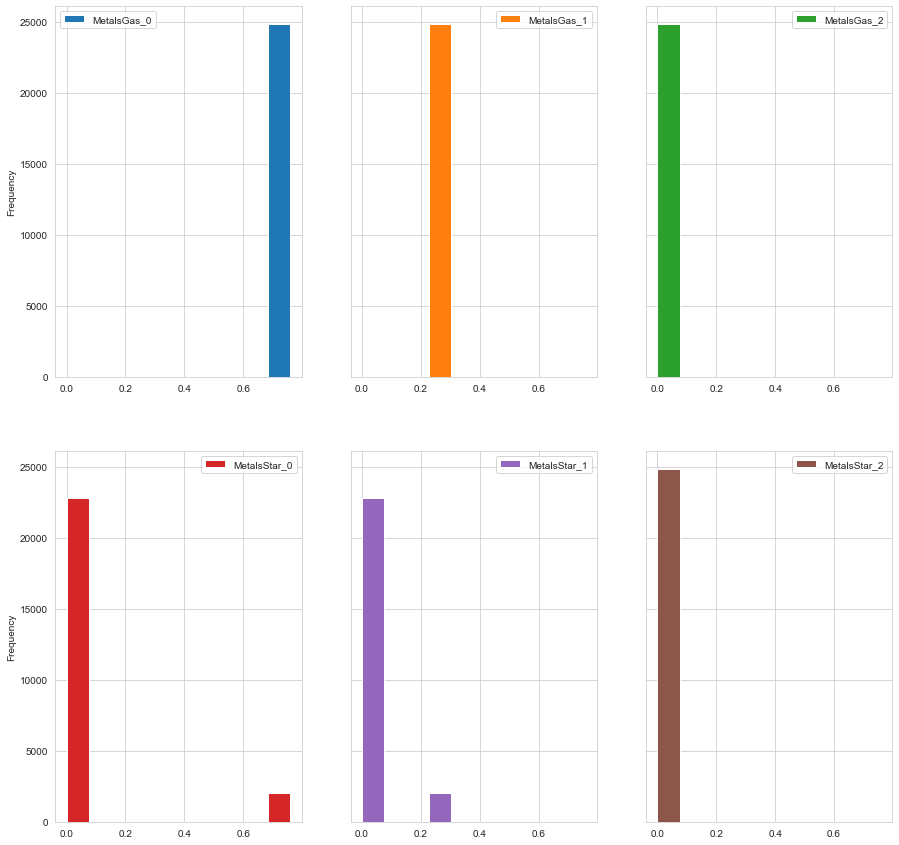

In [113]:
analysed_columns = ['MetalsGas_0','MetalsGas_1','MetalsGas_2','MetalsStar_0','MetalsStar_1','MetalsStar_2']
df[analysed_columns].plot(kind = 'hist',subplots = True, figsize = (15,15), layout = (2,3), sharey = True, sharex = False)

From the previous analysis we notice that, except for few observations, the analysed features tend to mantain the same value. Since they are not so discriminant, we avoid to use them in the following plot showing the distributions of each features and the scatter plot of every pair of variables.

We proceed to plot the distributions of each feature and the plot of each pair of feature in order to compute some preliminar analysis.

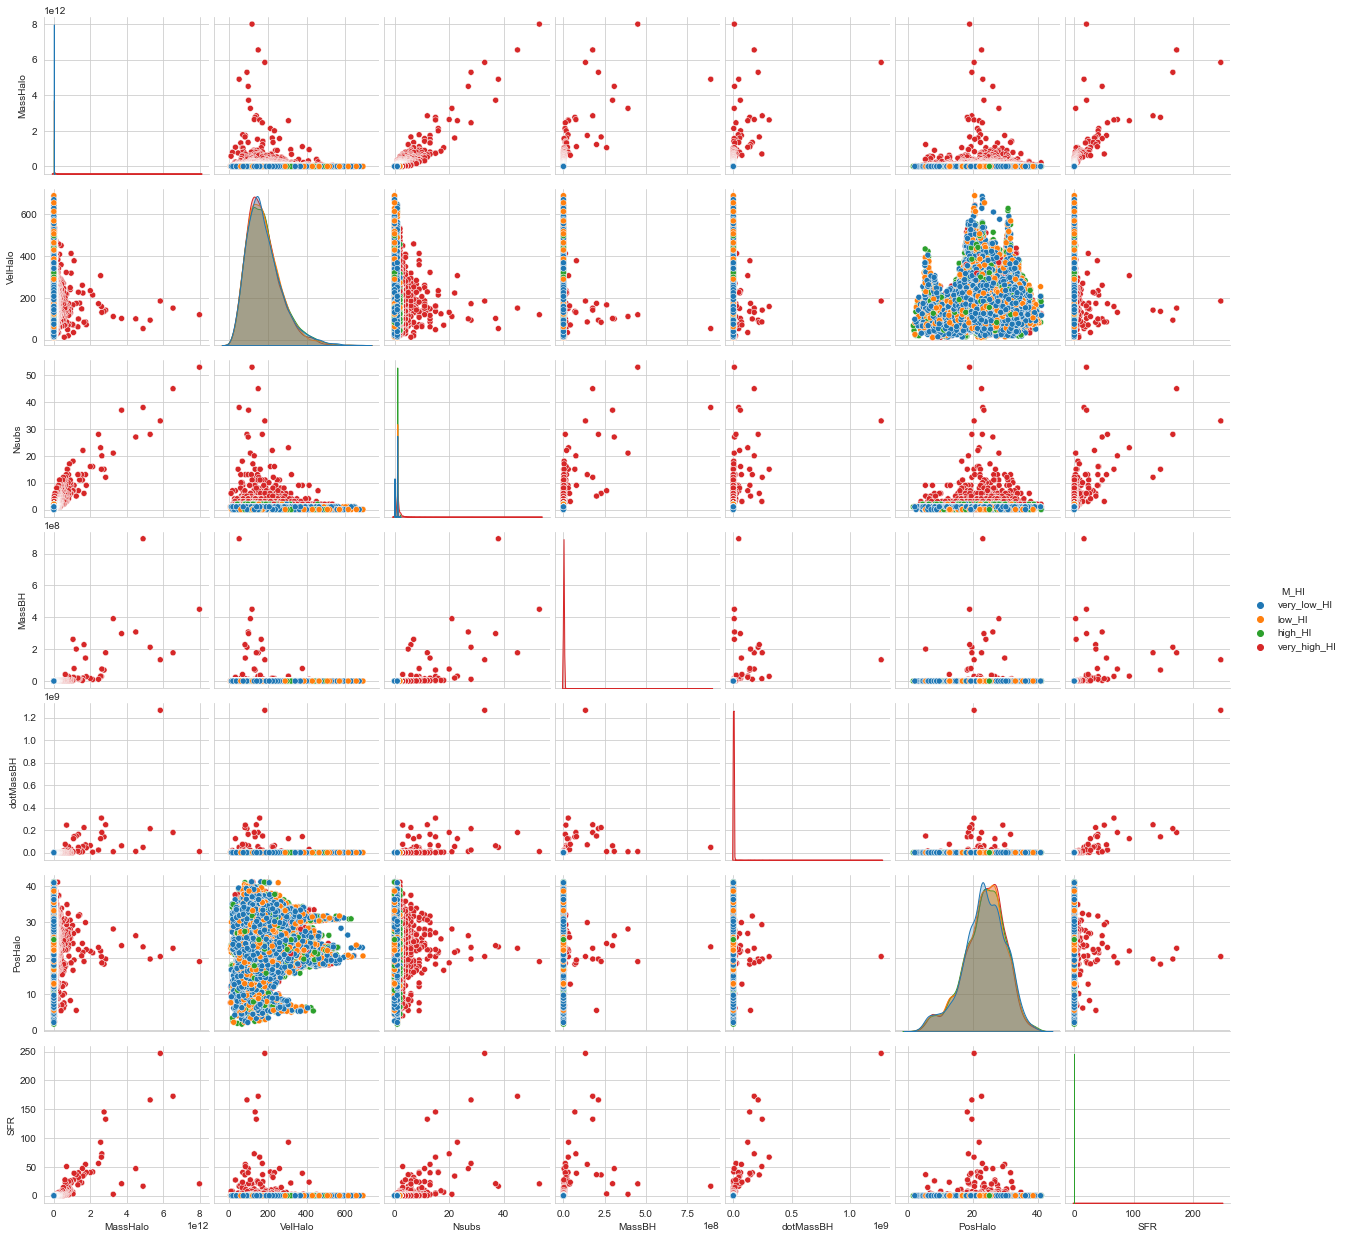

In [116]:
final_columns = ['MassHalo','VelHalo','Nsubs','MassBH','dotMassBH','PosHalo','SFR','M_HI']
sns.set_style("whitegrid")
sns.pairplot(df[final_columns],hue="M_HI")

#### Computing KMeansClustering to identify clusters and pattern/regularities in data

From the previous plot we notice a certain number of clusters in the data. Supposing not to know the actual value of M_HI, we want to use an unsupervised learning algorithm to label each data point. We expect that the actual aclssification returns a categorization which is different from the one made by us. While we only focus on the numerical value assumed by M_HI, we now want to capture regularities in the data. 

In [ ]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

We now visualize the curve in order to choose the optimal K (hyperparameter).

In [ ]:
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

After choosing the best K, we proceed to use KMeansClustering to assign label to each data point.

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(x)